In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
import matplotlib.pyplot as plt
import random as rd
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
from analyze_data import calculate_gini_coefficient
from plots import plot_Lorenz

from collections import defaultdict
from scipy import stats
from numpy.linalg import norm
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
# set plot style: grey grid in the background:
sns.set(style="darkgrid")
pd.set_option("display.precision", 8)

# Read data

In [15]:
top_fraction = 0.2

In [2]:
user_events_file = 'https://media.githubusercontent.com/media/SavvinaDaniil/UnfairnessOfPopularityBias/main/data/ratings_music.txt'

# read user events
item_col = "artist"
cols = ['user',item_col, 'album', 'track', 'timestamp']
df_events_music = pd.read_csv(user_events_file, sep = '\t', names = cols)

print('No. of user events: ' + str(len(df_events_music)))

No. of user events: 28718087


In [3]:
# create user-item matrix
df_events_music = df_events_music.groupby(['user', item_col]).size().reset_index(name='rating')
print('No. user-item interactions: ' + str(len(df_events_music)))

No. user-item interactions: 1755361


In [4]:
df_events_music = df_events_music.astype("int")

In [6]:
def users_and_items(df_events, user_col, item_col):
    print('No. user events: ' + str(len(df_events)))
    print('No. items: ' + str(len(df_events[item_col].unique())))
    print('No. users: ' + str(len(df_events[user_col].unique())))
    print("\n")
def user_distribution(df_events, user_col, item_col):
    user_dist = df_events[user_col].value_counts() 
    num_users = len(user_dist)
    print('Mean '+item_col+'s per user: ' + str(np.round(user_dist.mean(),1))) 
    print('Min '+item_col+'s per user: ' + str(np.round(user_dist.min(),1))) 
    print('Max '+item_col+'s per user: ' + str(np.round(user_dist.max(),1)))
    print("\n")
    return user_dist, num_users
def item_distribution(df_events, user_col, item_col):
    item_dist = df_events[item_col].value_counts()
    num_items = len(item_dist)
    print('Mean users per '+item_col+': ' + str(np.round(item_dist.mean(),1))) 
    print('Min users per '+item_col+': ' + str(np.round(item_dist.min(),1))) 
    print('Max users per '+item_col+': ' + str(np.round(item_dist.max(),1))) 
    print("\n")
    return item_dist, num_items

In [7]:
users_and_items(df_events_music, "user", item_col)
user_dist_music, num_users_music = user_distribution(df_events_music, "user", item_col)
item_dist_music, num_items_music = item_distribution(df_events_music, "user", item_col)

No. user events: 1755361
No. items: 352805
No. users: 3000


Mean artists per user: 585.1
Min artists per user: 18
Max artists per user: 4011


Mean users per artist: 5.0
Min users per artist: 1
Max users per artist: 1389




In [16]:
num_top_music = int(top_fraction * num_items_music)
top_item_dist_music = item_dist_music[:num_top_music]
print('No. top artists: ' + str(len(top_item_dist_music)))

No. top artists: 70561


In [9]:
def calculate_popularity_for_music(df_events, top_item_dist, item_dist, num_users, user_col, item_col, low_users, medium_users, high_users):
    pop_count = [] # number of top items per user
    user_hist = [] # user history sizes
    pop_fraq = [] # relative number of top items per user
    pop_item_fraq = [] # average popularity of items in user profiles
    low_profile_size = 0
    low_gap = 0
    medium_profile_size = 0
    medium_gap = 0
    high_profile_size = 0
    high_gap = 0
    low_ratio = 0
    medium_ratio = 0
    high_ratio = 0
    
    i=0
    for u, df in df_events.groupby(user_col):
        no_user_items = len(set(df[item_col]))
        no_user_pop_items = len(set(df[item_col]) & set(top_item_dist.index))
        pop_count.append(no_user_pop_items)
        user_hist.append(no_user_items) 
        pop_fraq.append(no_user_pop_items / no_user_items)
        user_pop_item_fraq = sum(item_dist[df[item_col]] / num_users) / no_user_items
        pop_item_fraq.append(user_pop_item_fraq)
    
        if u in low_users.index: # get user group-specific values
            low_profile_size += no_user_items
            low_gap += user_pop_item_fraq
            low_ratio += no_user_pop_items / no_user_items
        elif u in medium_users.index:
            medium_profile_size += no_user_items
            medium_gap += user_pop_item_fraq
            medium_ratio += no_user_pop_items / no_user_items
        else:
            high_profile_size += no_user_items
            high_gap += user_pop_item_fraq
            high_ratio += no_user_pop_items / no_user_items
        i+=1
        if i%1000==0:
            print(i)
    low_profile_size /= len(low_users)
    medium_profile_size /= len(medium_users)
    high_profile_size /= len(high_users)
    low_ratio /= len(low_users)
    medium_ratio /= len(medium_users)
    high_ratio /= len(high_users)
    low_gap /= len(low_users)
    medium_gap /= len(medium_users)
    high_gap /= len(high_users)
  
    return pop_count,user_hist,pop_fraq, pop_item_fraq, low_profile_size, medium_profile_size, high_profile_size, low_gap, medium_gap, high_gap, low_ratio, medium_ratio, high_ratio

In [10]:
low_user_file = "https://media.githubusercontent.com/media/SavvinaDaniil/UnfairnessOfPopularityBias/main/data/low_main_users.txt"
medium_user_file = "https://media.githubusercontent.com/media/SavvinaDaniil/UnfairnessOfPopularityBias/main/data/medium_main_users.txt"
high_user_file = "https://media.githubusercontent.com/media/SavvinaDaniil/UnfairnessOfPopularityBias/main/data/high_main_users.txt"

In [12]:
def read(low_user_file, medium_user_file, high_user_file):
    low_users = pd.read_csv(low_user_file, sep=',').set_index('user_id')
    medium_users = pd.read_csv(medium_user_file, sep=',').set_index('user_id')
    high_users = pd.read_csv(high_user_file, sep=',').set_index('user_id')
    no_users = len(low_users) + len(medium_users) + len(high_users)
    print('No. of users: ' + str(no_users))
    
    mainstreaminess = "M_global_R_APC"
    
    print('Average mainstreaminess per user for low: ' + str(low_users[mainstreaminess].mean()))
    print('Average mainstreaminess per user for med: ' + str(medium_users[mainstreaminess].mean()))
    print('Average mainstreaminess per user for high: ' + str(high_users[mainstreaminess].mean()))
    return no_users, low_users, medium_users, high_users

In [13]:
num_users_music, low_music, med_music, high_music= read(low_user_file, medium_user_file, high_user_file)

No. of users: 3000
Average mainstreaminess per user for low: 0.009333709599999998
Average mainstreaminess per user for med: 0.18199761010999999
Average mainstreaminess per user for high: 0.33798161341000005


In [17]:
pop_count_music,user_hist_music,pop_fraq_music, pop_item_fraq_music, low_profile_size_music, med_profile_size_music, high_profile_size_music, low_GAP_music, med_GAP_music, high_GAP_music, low_ratio_music, med_ratio_music, high_ratio_music = calculate_popularity_for_music(df_events_music, top_item_dist_music, item_dist_music, num_users_music, "user", "artist", low_music, med_music, high_music)

1000
2000
3000


# Plot

In [18]:
def plot_data_distribution(item_dist, item_col, dividing = [False, 0], log = False, save = False, addition = ""):
    plt.figure()
    ax = plt.axes()
    ax.spines['bottom'].set_color('w')
    ax.spines['top'].set_color('w')
    ax.spines['right'].set_color('w')
    ax.spines['left'].set_color('w')
    ax.spines['left'].set_zorder(0)
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 
    ax.set_facecolor("aliceblue")
    plt.grid(color = "w",linewidth = 2 )
    if dividing[0]:
        x0 = int(len(item_dist.values)*dividing[1])
        y = range(len(item_dist))
        plt.plot(y[:x0+1], item_dist.values[:x0+1], label = "Popular "+item_col+"s", linewidth = 5)
        plt.plot(y[x0:], item_dist.values[x0:], label = "Non Popular "+item_col+"s", linewidth = 5)
    else:
        plt.plot(item_dist.values)
    plt.xticks(fontsize='13')
    plt.yticks(fontsize='13')
    add = ""
    if log:
        plt.xscale('log')
        plt.yscale('log')
        add = "_(log)"
    plt.xlabel(item_col+add, fontsize='14')
    plt.ylabel('Number of users' + add, fontsize='15')
    if save:
        if dividing[0]:
            plt.savefig('graphs/'+item_col+add+"_dist_div"+addition+".png", bbox_inches='tight')
        else:
            plt.savefig('graphs/'+item_col+add+"_dist"+addition+".png", bbox_inches='tight')
    plt.show(block=True)

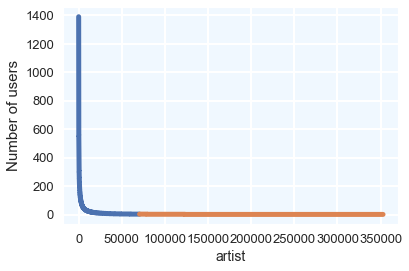

In [21]:
plot_data_distribution(item_dist_music, item_col, dividing = [True, top_fraction])

# Process

In [79]:
limit = 20

In [80]:
relevant_items = list(item_dist_music[item_dist_music>limit].index)

In [81]:
len(relevant_items)

12690

In [82]:
relevant_df_events_music = df_events_music[df_events_music.artist.isin(relevant_items)]

In [83]:
len(relevant_df)

1008479

In [84]:
users_and_items(relevant_df_events_music, "user", item_col)


No. user events: 1008479
No. items: 12690
No. users: 3000




In [85]:
relevant_df_events_music.groupby("user").size().sort_values()

user
10883488       4
23784719       5
19807934       9
47763936      14
32504538      15
            ... 
21920371    1834
5857001     1837
10011960    1863
33171261    1906
4393555     2057
Length: 3000, dtype: int64

In [86]:
users_and_items(relevant_df_events_music, "user", item_col)
user_dist_music, num_users_music = user_distribution(relevant_df_events_music, "user", item_col)
item_dist_music, num_items_music = item_distribution(relevant_df_events_music, "user", item_col)

No. user events: 1008479
No. items: 12690
No. users: 3000


Mean artists per user: 336.2
Min artists per user: 4
Max artists per user: 2057


Mean users per artist: 79.5
Min users per artist: 21
Max users per artist: 1389




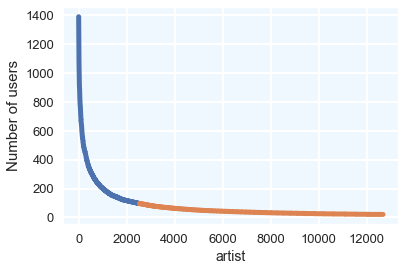

In [87]:
plot_data_distribution(item_dist_music, item_col, dividing = [True, top_fraction])

In [89]:
relevant_df_events_music.to_csv("data/relevant_music_data_20.csv")